<a href="https://colab.research.google.com/github/AARABAabdallah/RNAclassification/blob/master/RNApreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install Biopython

In [0]:
#!ls drive/My\ Drive/Colab\ Workspace/RNA_classification/DataSet/fasta_to_csv

In [0]:
source_dir = Path('fasta_files')
files = source_dir.iterdir()
files = source_dir.glob('RF0000*.fa')
#print(files)
for i,file in enumerate(files):
    filePath = str(file)
    family = int(filePath[-8:-3])
    print("family is: ", family)
    if family == 5: #tRNA family: +250MB
        continue
    df = pd.DataFrame(columns = ['id', 'sequence', 'family'])
    for j,seq_record in enumerate(SeqIO.parse(file, "fasta")):
        df.at[j,'id'] = seq_record.id
        df.at[j,'sequence']  = str(seq_record.seq)
        df.at[j,'family'] = family
        if j % 1000 == 0:
            print(j)
    string_to_display = "%05d" % (family,)
    df.to_csv(str('drive/My Drive/Colab Workspace/RNA_classification/DataSet/fasta_to_csv/RF'+ string_to_display +'.csv'))
    #drive/My\ Drive/Colab\ Workspace/RNA_classification/DataSet/fasta_to_csv
    #if i >= 3:
    #    break
    print("next_file: ",i)

# ***Now :***

1.   we should load all the 8 csv files into 8 data frames. 
2.   Split each data frame into train & test data sets. 
1.   Regroup all training data frames into one trining df, and the same thing for the test df.
1.   Then shuffle the two data frames.
2.   Train the RNN LSTM model
2.   Test the model
1.   ANalyze the results

![Texte alternatif…](https://oncoml.files.wordpress.com/2019/09/lstm_many_to_one.png)








In [0]:
!ls drive/My\ Drive/Colab\ Workspace/RNA_classification/DataSet/fasta_to_csv

RF00001.csv  RF00003.csv  RF00006.csv  RF00008.csv
RF00002.csv  RF00004.csv  RF00007.csv  RF00009.csv


In [0]:
#load all the 8 csv files into 8 data frames.
source_dir = Path('drive/My Drive/Colab Workspace/RNA_classification/DataSet/fasta_to_csv/')
files = source_dir.iterdir()
files = source_dir.glob('RF0000*.csv')
frames = []
#print(files)
for i,file in enumerate(files):
    #print(file)
    filePath = str(file)
    df = pd.read_csv(filePath)
    df = df.drop([df.columns[0],df.columns[1]], axis=1) # So not to dupplicate the index column !
    frames.append(df)
    #print("next_file: ",i)
    #if i >= 2:
    #  break
#df_result = pd.concat(frames, ignore_index=True)
#df_result
frames

In [0]:
#split each data frame into train & test data sets.

X_train_arrays = []
y_train_arrays = []
X_test_arrays = []
y_test_arrays = []
for df in frames:
  X = np.array(df.sequence)
  y = np.array(df.family)
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.25, shuffle=True)
  X_train_arrays.append(X_train)
  y_train_arrays.append(y_train)
  X_test_arrays.append(X_test)
  y_test_arrays.append(y_test)

X_train = np.concatenate(X_train_arrays)
y_train = np.concatenate(y_train_arrays)
X_test = np.concatenate(X_test_arrays)
y_test = np.concatenate(y_test_arrays)

#Train with seed all data file !

In [2]:
#from pathlib import Path
#from Bio import SeqIO
#import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import tnrange
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from librosa.util import pad_center
from time import time
import datetime
import pickle

In [0]:
data = pd.read_csv('drive/My Drive/Colab Workspace/RNA_classification/DataSet/All_RNA_Families_IdSeqTotal_IdFamily_Seq.csv')

In [0]:
#Split data
X = np.array(data.sequence)
y = np.array(data.id_family)
family_labels = np.unique(np.array(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [5]:
print(len(X_train))
print(len(X_test))

54039
18013


In [6]:
#Données de validations !
X_val1, X_val, y_val1, y_val = train_test_split(X_test, y_test, test_size=0.17)
len(X_val)

3063

In [0]:
X_train_copy = np.copy(X_train)
X_test_copy = np.copy(X_test)
X_val = np.copy(X_val)
#X_train_copy[:5]
#len(X_train_copy[0])

In [0]:
X_train = np.copy(X_train_copy)
X_test = np.copy(X_test_copy)
X_val = np.copy(X_val)

In [9]:
X_train.shape

(54039,)

In [10]:
# zero padding X_train pour booster l'entrainement
train_max_sequence = np.max([len(X_train[i]) for i in range(len(X_train))])
train_position_max_sequence = np.argmax([len(X_train[i]) for i in range(len(X_train))])
print(train_max_sequence)
train_position_max_sequence
### Zero padding validation ###
val_max_sequence = np.max([len(X_val[i]) for i in range(len(X_val))])
val_position_max_sequence = np.argmax([len(X_val[i]) for i in range(len(X_val))])
print(val_max_sequence)
val_position_max_sequence

4065
3363


1410

In [0]:
### Pading data strings
#padding_array = X_train[0].ljust(max_sequence, '0')
#padding_array

In [0]:
### Pading data strings ###
def zero_padding_training_data_string(data, max_seq):
  #temp = np.copy(data)
  for i in tnrange(0, len(data)):
    data[i] = data[i].ljust(max_seq, '0')
  #return temp

In [13]:
### Pading training data strings X_train###
zero_padding_training_data_string(X_train, max_seq=train_max_sequence)

In [14]:
X_train.shape

(54039,)

In [15]:
### Pading validation data strings X_train###
zero_padding_training_data_string(X_val, val_max_sequence)

In [16]:
X_val.shape

(3063,)

In [0]:
 #Turning data into one hot coding
 
 def oneHot_encode(data):
  if isinstance(data,str) : # input is a string
    input_list = np.array(list(data))
    output = []
    for i in range(len(input_list)):
      if input_list[i] == 'A':
        output.append(np.array([1, 0, 0, 0]))
      elif input_list[i] == 'C':
        output.append(np.array([0, 1, 0, 0]))
      elif input_list[i] == 'G':
        output.append(np.array([0, 0, 1, 0]))
      elif input_list[i] == 'T':
        output.append(np.array([0, 0, 0, 1]))
      else :    #Padding !!
        output.append(np.array([0, 0, 0, 0]))
    return output
  else: # input is an array of strings
    return np.array([ np.array(oneHot_encode(data[i])) for i in tnrange(int(data.shape[0]))])
 

In [18]:
X_train = oneHot_encode(X_train)
X_test = oneHot_encode(X_test)
X_val = oneHot_encode(X_val)

In [0]:
y_train_copy = np.copy(y_train)
y_test_copy = np.copy(y_test)
y_val_copy = np.copy(y_val)

In [0]:
y_train = np.copy(y_train_copy)
y_test = np.copy(y_test_copy)
y_val = np.copy(y_val_copy)

In [21]:
print(len(np.unique(y_train)))
print(len(np.unique(y_val)))

3016
1168


In [0]:
# OneHot Encoding labels: Just for now !!!
def one_hot_encode_labels(labels):
  output = []
  for i in tnrange(len(labels)):
    output_i = np.zeros(len(family_labels), dtype=int)
    output_i[labels[i]] = 1
    output.append(output_i)
  return np.array(output)

In [23]:
y_train = one_hot_encode_labels(y_train)
y_test = one_hot_encode_labels(y_test)
y_val = one_hot_encode_labels(y_val)

In [24]:
y_train.shape

(54039, 3016)

In [25]:
# Model Creation
from keras.models import Sequential
from keras.layers import LSTM, Input, Dense, Activation, Embedding

model = Sequential()

#model.add(Embedding(input_dim=4, output_dim=16, input_length=None))
model.add(LSTM(32, return_sequences=False, input_shape=(None, 4)))
model.add(Dense(len(family_labels),name='out_layer', activation='softmax'))
model.summary(90)

Using TensorFlow backend.


Model: "sequential_1"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
lstm_1 (LSTM)                           (None, 32)                          4736          
__________________________________________________________________________________________
out_layer (Dense)                       (None, 3016)                        99528         
Total params: 104,264
Trainable params: 104,264
Non-trainable params: 0
__________________________________________________________________________________________


In [0]:
X_train_init = X_train
y_train_init = y_train
def train_generator():
    i = 0
    #while i < len(X_train_init):
    while True:
        if i == len(X_train_init):
          i = 0
        x_tr = (X_train_init[i]).reshape(1, len(X_train_init[i]), 4)
        y_tr = y_train_init[i].reshape(1,len(y_train_init[i]))
        yield x_tr, y_tr
        i += 1

In [0]:
# model training with train_generator ==> without batch optimization
model.compile(loss='categorical_crossentropy', optimizer='adam')
history = model.fit(train_generator(), steps_per_epoch=len(X_train_init), epochs=1, verbose=1, )

In [27]:
print(X_val.shape)
print(X_train.shape)
print(y_train.shape)
print(y_val.shape)

(3063, 3363, 4)
(54039, 4065, 4)
(54039, 3016)
(3063, 3016)


In [0]:
model.load_weights("drive/My Drive/Colab Workspace/RNA_classification/models/LSTM_OneHot_Batch.h5")

In [28]:
# model training without train_generator ==> wit batch optimization

#X_train_init = X_train_padded.reshape()
#X_train_init = X_train
#y_train_init = y_train
#y_train_init = y_train[:1000]

#log_dir="drive/My Drive/Colab Workspace/RNA_classification/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val) ,epochs=10, verbose=1)#, callbacks=[tensorboard_callback])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 54039 samples, validate on 3063 samples
Epoch 1/10





 8864/54039 [===>..........................] - ETA: 59:39 - loss: 7.1892 - acc: 0.0166

KeyboardInterrupt: ignored

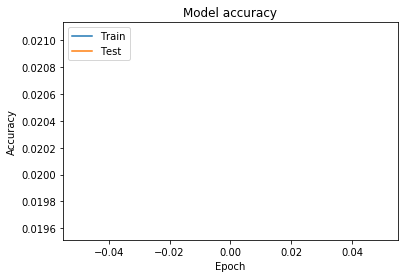

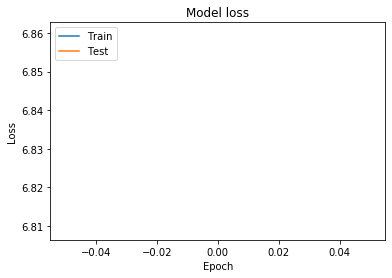

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.save_weights("drive/My Drive/Colab Workspace/RNA_classification/models/LSTM_OneHot_Batch.h5")
history_file_name = 'drive/My Drive/Colab Workspace/RNA_classification/models/trainHistoryDict'
with open(history_file_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [0]:
#from tqdm import tnrange
def model_accuracy(data_test, labels_test):
  acc = 0
  for i in tnrange(len(data_test), desc='testing progress'):
    if np.argmax(model.predict(data_test[i].reshape(1, len(X_test[i]), 4))) == np.argmax(labels_test[i]):
      acc += 1
  return (acc/len(data_test))*100

In [0]:
accuracy = model_accuracy(X_test[:5000], y_test[:5000])
print("the model's accuracy is: ", accuracy, "%")


the model's accuracy is:  2.18 %
